Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)


# Building a scan programatically

In this notebook we'll build up a scan definition from first principles, against a local model trained within the
notebook.  We will then run that scan and save its results.  Finally we will extract the scan defintion as YAML, which could be used to run the same scan (potentially on revised models or datasets) via the Certifai stand-alone scanner.

In [1]:
import pandas as pd
import pprint
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model = build_model((encoder(X_train.values), y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'Support Vector Machine' accuracy is 0.77
Model 'Logistic classifier' accuracy is 0.77


In [3]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)

In [4]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_use_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

In [5]:
# Run a preflight scan
# The preflight scan will run various checks against each model to alert about possible situations
# that may impact your scan, as well as produce a time estimate for your scan. A preflight report
# will be written per model that contains various data from the preflight scan, which will be
# used to offer time estimates when running future scans.
preflight_result = scan.run_preflight()

# The result is a dictionary of dictionaries of observations from the preflight scan. The top
# level dict key is the model id and the second level is the type of observation (e.g. messages, warnings, errors)
pprint.pprint(preflight_result)

2023-01-04 17:58:34,959 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


Starting Preflight Scan
[--------------------] 2023-01-04 17:58:34.917041 - 0 of 10 checks (0.0% complete) - Running model nondeterminism preflight check for model SVM
[##------------------] 2023-01-04 17:58:34.949056 - 1 of 10 checks (10.0% complete) - Running scan time estimate preflight check for model SVM


2023-01-04 18:01:06,913 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


[####----------------] 2023-01-04 18:01:06.868127 - 2 of 10 checks (20.0% complete) - Running one hot checker class preflight check for model SVM
[######--------------] 2023-01-04 18:01:06.868317 - 3 of 10 checks (30.0% complete) - Running unknown outcome class preflight check for model SVM
[########------------] 2023-01-04 18:01:06.875923 - 4 of 10 checks (40.0% complete) - Running fairness class samples preflight check for model SVM
[##########----------] 2023-01-04 18:01:06.879113 - 5 of 10 checks (50.0% complete) - Finished all preflight checks for model SVM
[##########----------] 2023-01-04 18:01:06.879160 - 5 of 10 checks (50.0% complete) - Running model nondeterminism preflight check for model logistic
[############--------] 2023-01-04 18:01:06.902483 - 6 of 10 checks (60.0% complete) - Running scan time estimate preflight check for model logistic
[##############------] 2023-01-04 18:01:53.761191 - 7 of 10 checks (70.0% complete) - Running one hot checker class preflight check f

In [6]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2023-01-04 18:01:53,836 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


Starting scan with model_use_case_id: 'test_use_case' and scan_id: '177840c13e04', total estimated time is 11 minutes
[--------------------] 2023-01-04 18:01:53.823763 - 0 of 4 reports (0.0% complete) - Running fairness evaluation for model: SVM, estimated time is 463 seconds


2023-01-04 18:03:13,347 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-04 18:03:45,646 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-04 18:05:06,870 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2023-01-04 18:06:12,643 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-04 18:06:19,642 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples
2023-01-04 18:06:19,643 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2023-01-04 18:06:31,717 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence 

[#####---------------] 2023-01-04 18:06:31.704480 - 1 of 4 reports (25.0% complete) - Running atx evaluation for model: SVM
[##########----------] 2023-01-04 18:06:31.706458 - 2 of 4 reports (50.0% complete) - Running fairness evaluation for model: logistic, estimated time is 153 seconds


2023-01-04 18:07:01,378 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-04 18:07:23,908 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-04 18:07:36,432 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2023-01-04 18:07:59,070 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-04 18:08:01,972 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples
2023-01-04 18:08:01,973 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples


[###############-----] 2023-01-04 18:08:14.121980 - 3 of 4 reports (75.0% complete) - Running atx evaluation for model: logistic
[####################] 2023-01-04 18:08:14.123639 - 4 of 4 reports (100.0% complete) - Completed all evaluations


In [7]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
print(type(result['fairness']['SVM']['fairness']['secondary_scores']))
df = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df)

<class 'list'>


,context,type,fairness,Feature (age),type in Feature (age),Group details (<= 25 years),type in Feature (age),Group details (> 25 years),Feature (status),type in Feature (status),Group details (female : divorced/separated/married),type in Feature (status),Group details (male : divorced/separated),type in Feature (status),Group details (male : married/widowed),type in Feature (status),Group details (male : single)
SVM (burden),SVM,burden,71.136681,73.583428,burden,0.074341,burden,0.043153,71.136681,burden,0.070199,burden,0.062857,burden,0.024193,burden,0.039666
logistic (burden),logistic,burden,68.744011,68.744011,burden,0.081351,burden,0.042567,72.706751,burden,0.074222,burden,0.074287,burden,0.032653,burden,0.036696


,context,type,fairness,Feature (age),Feature (age) lower bound,Feature (age) upper bound,type in Feature (age),Group details (<= 25 years),Group details (<= 25 years) lower bound,Group details (<= 25 years) upper bound,...,Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,type in Feature (status),Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,type in Feature (status),Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
SVM (burden),SVM,burden,71.136681,73.583428,63.750788,84.781690,burden,0.074341,0.060661,0.088053,...,0.037037,0.093617,burden,0.024193,0.014351,0.035274,burden,0.039666,0.033515,0.046266
logistic (burden),logistic,burden,68.744011,68.744011,59.408830,78.548514,burden,0.081351,0.067989,0.095596,...,0.049132,0.102472,burden,0.032653,0.020000,0.046073,burden,0.036696,0.030438,0.043301


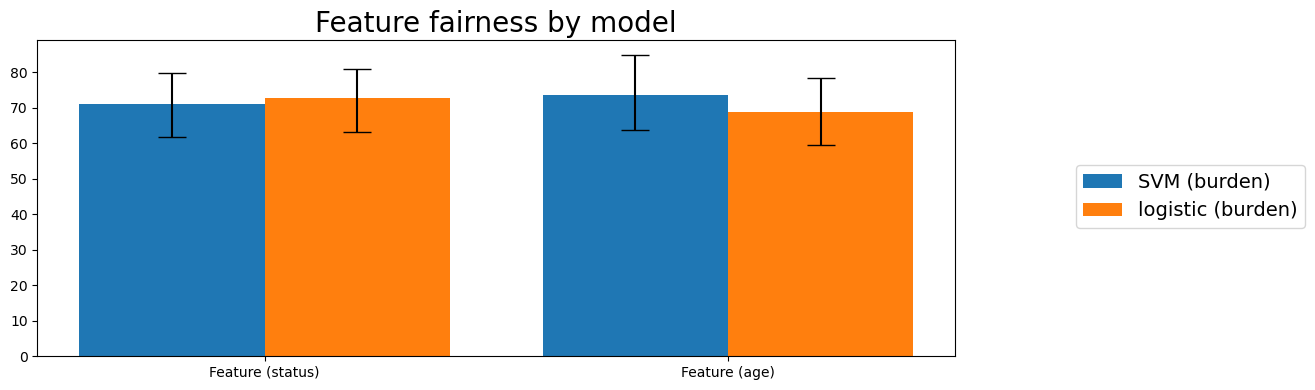

In [8]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))

display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

In [9]:
# We can also persist the template we built and reuse it later as illustrated here
import tempfile
import yaml

temp_file = tempfile.mktemp()
with open(temp_file, "w") as f:
    scan.save(f)
    print(f"Saved template to: {temp_file}")

2023-01-04 18:08:14,370 root   WARNING  The model 'SVM' was locally defined and cannot be represented within a scan definition because it doesn't have a 'predict_endpoint'. A default value of '<UNKNOWN_ENDPOINT>' will be used in the exported YAML for the models 'predict_endpoint'. Before running a scan with the exported YAML, you should deploy the model and update the 'SVM' models metadata in the scan definition.
2023-01-04 18:08:14,371 root   WARNING  The model 'logistic' was locally defined and cannot be represented within a scan definition because it doesn't have a 'predict_endpoint'. A default value of '<UNKNOWN_ENDPOINT>' will be used in the exported YAML for the models 'predict_endpoint'. Before running a scan with the exported YAML, you should deploy the model and update the 'logistic' models metadata in the scan definition.


Saved template to: /var/folders/fp/61zjyp_54tv05lfbp3vwp72c0000gq/T/tmpkiz29if_


In [10]:
reloaded = CertifaiScanBuilder.from_file(temp_file)

# The persisted scan won't contain the model itself, so we'll need to reconnect that
for model in reloaded.models:
    if model.id == 'logistic':
        model.local_predictor=logistic_model_proxy
    elif model.id == 'SVM':
        model.local_predictor=svm_model_proxy

2023-01-04 18:08:14,393 root   WARNING  The model 'SVM' was locally defined and doesn't have a valid 'predict_endpoint'. Before running a scan with this model, you should deploy the model and update the 'SVM' models metadata in the scan definition.
2023-01-04 18:08:14,394 root   WARNING  The model 'logistic' was locally defined and doesn't have a valid 'predict_endpoint'. Before running a scan with this model, you should deploy the model and update the 'logistic' models metadata in the scan definition.


In [11]:
result = reloaded.run(write_reports=False)

2023-01-04 18:08:14,454 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


[--------------------] 2023-01-04 18:08:14.442335 - 0 of 4 reports (0.0% complete) - Starting scan with model_use_case_id: 'test_use_case' and scan_id: '8f29b073bed7', total estimated time is 11 minutes
[--------------------] 2023-01-04 18:08:14.442494 - 0 of 4 reports (0.0% complete) - Running fairness evaluation for model: SVM, estimated time is 463 seconds


2023-01-04 18:09:35,420 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-04 18:10:07,524 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-04 18:11:14,726 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2023-01-04 18:12:19,501 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-04 18:12:26,852 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples
2023-01-04 18:12:26,853 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2023-01-04 18:12:39,205 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence 

[#####---------------] 2023-01-04 18:12:39.193556 - 1 of 4 reports (25.0% complete) - Running atx evaluation for model: SVM
[##########----------] 2023-01-04 18:12:39.195557 - 2 of 4 reports (50.0% complete) - Running fairness evaluation for model: logistic, estimated time is 153 seconds


2023-01-04 18:13:09,309 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-04 18:13:31,680 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-04 18:13:43,901 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2023-01-04 18:14:06,437 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-04 18:14:09,321 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples
2023-01-04 18:14:09,322 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples


[###############-----] 2023-01-04 18:14:21.225232 - 3 of 4 reports (75.0% complete) - Running atx evaluation for model: logistic
[####################] 2023-01-04 18:14:21.227036 - 4 of 4 reports (100.0% complete) - Completed all evaluations


In [12]:
construct_scores_dataframe(scores('fairness', result), include_confidence=False)

,context,type,fairness,Feature (age),type in Feature (age),Group details (<= 25 years),type in Feature (age),Group details (> 25 years),Feature (status),type in Feature (status),Group details (female : divorced/separated/married),type in Feature (status),Group details (male : divorced/separated),type in Feature (status),Group details (male : married/widowed),type in Feature (status),Group details (male : single)
SVM (burden),SVM,burden,71.136681,73.583428,burden,0.074341,burden,0.043153,71.136681,burden,0.070199,burden,0.062857,burden,0.024193,burden,0.039666
logistic (burden),logistic,burden,68.744011,68.744011,burden,0.081351,burden,0.042567,72.706751,burden,0.074222,burden,0.074287,burden,0.032653,burden,0.036696


In [13]:
# We can also process dataframes we have locally already loaded in Pandas rather than
# requiring them to initially be saved off as CSV/JSON files
df2 = pd.read_csv(all_data_file)

# Add this already loaded data as a new dataset and switch to evaluate it
loaded_dataset = CertifaiDataset('loaded', CertifaiDatasetSource.dataframe(df2))
reloaded.add_dataset(loaded_dataset)
reloaded.evaluation_dataset_id = 'loaded'

result = reloaded.run()

2023-01-04 18:14:21,302 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


[--------------------] 2023-01-04 18:14:21.292462 - 0 of 4 reports (0.0% complete) - Starting scan with model_use_case_id: 'test_use_case' and scan_id: 'f38985b0b102', total estimated time is 11 minutes
[--------------------] 2023-01-04 18:14:21.292643 - 0 of 4 reports (0.0% complete) - Running fairness evaluation for model: SVM, estimated time is 463 seconds


2023-01-04 18:15:41,396 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-04 18:16:13,870 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-04 18:17:23,136 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2023-01-04 18:18:29,081 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-04 18:18:36,186 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples
2023-01-04 18:18:36,187 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2023-01-04 18:18:48,234 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence 

[#####---------------] 2023-01-04 18:18:48.221905 - 1 of 4 reports (25.0% complete) - Running atx evaluation for model: SVM
[##########----------] 2023-01-04 18:18:48.224778 - 2 of 4 reports (50.0% complete) - Running fairness evaluation for model: logistic, estimated time is 153 seconds


2023-01-04 18:19:18,733 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-04 18:19:41,359 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-04 18:19:53,738 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2023-01-04 18:20:16,711 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-04 18:20:19,655 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples
2023-01-04 18:20:19,656 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples


[###############-----] 2023-01-04 18:20:31.869805 - 3 of 4 reports (75.0% complete) - Running atx evaluation for model: logistic
[####################] 2023-01-04 18:20:31.872244 - 4 of 4 reports (100.0% complete) - Completed all evaluations


In [14]:
construct_scores_dataframe(scores('fairness', result), include_confidence=False)

,context,type,fairness,Feature (age),type in Feature (age),Group details (<= 25 years),type in Feature (age),Group details (> 25 years),Feature (status),type in Feature (status),Group details (female : divorced/separated/married),type in Feature (status),Group details (male : divorced/separated),type in Feature (status),Group details (male : married/widowed),type in Feature (status),Group details (male : single)
SVM (burden),SVM,burden,71.136681,73.583428,burden,0.074341,burden,0.043153,71.136681,burden,0.070199,burden,0.062857,burden,0.024193,burden,0.039666
logistic (burden),logistic,burden,68.744011,68.744011,burden,0.081351,burden,0.042567,72.706751,burden,0.074222,burden,0.074287,burden,0.032653,burden,0.036696


In [15]:
# Having developed a scan definition we'll eventually want to be able to export it for use in
# scans of a deployed model.  The main differences then will be:
#  * The model won't be local to the scanner, but will be accessed via the network
#  * The dataset won't be in a local DataFrame but will always be read from (possibly network attached) storage
# This means that the scan template used by the scanner will need dataset sourcing details filling in, and model
# endpoint address specifying.  This can either be done by a post-hoc hand edit of the produced YAML (the file we
# saved off earlier to illustrate persisting the template), or we can add those details programatically prior to
# exporting as illustrated below
exportable_scan = CertifaiScanBuilder.from_file(temp_file)  # reload the scan we've been using in the notebook
exportable_scan.models[0].predict_endpoint = 'http://mymodel/predict'
exportable_scan.datasets[0].source = CertifaiDatasetSource.csv('somefile.csv')

# Export the updated scan as YAML for use by the scanner (we won't actually save it here - just print it)
scan_yaml = exportable_scan.extract_yaml() # could use the method `save` to write direct to a file
print(scan_yaml)

2023-01-04 18:20:31,906 root   WARNING  The model 'SVM' was locally defined and doesn't have a valid 'predict_endpoint'. Before running a scan with this model, you should deploy the model and update the 'SVM' models metadata in the scan definition.
2023-01-04 18:20:31,907 root   WARNING  The model 'logistic' was locally defined and doesn't have a valid 'predict_endpoint'. Before running a scan with this model, you should deploy the model and update the 'logistic' models metadata in the scan definition.


datasets:
- dataset_id: evaluation
  url: somefile.csv
  has_header: true
  file_type: csv
  delimiter: ','
  quote_character: '"'
models:
- model_id: SVM
  name: SVM
  predict_endpoint: http://mymodel/predict
  prediction_value_order:
  - 1
  - 2
- model_id: logistic
  name: logistic
  predict_endpoint: <UNKNOWN_ENDPOINT>
  prediction_value_order:
  - 1
  - 2
model_use_case:
  name: test_use_case
  model_use_case_id: test_use_case
  task_type: binary-classification
evaluation:
  evaluation_dataset_id: evaluation
  evaluation_types:
  - fairness
  fairness_grouping_features:
  - name: age
  - name: status
  prediction_values:
  - name: Loan granted
    value: 1
    favorable: true
  - name: Loan denied
    value: 2
    favorable: false
  prediction_favorability: explicit
  name: test_use_case
  prediction_description: Determine whether a loan should be granted
dataset_schema:
  outcome_column: outcome

